In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('telcom_data.csv')

In [3]:
df

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311450e+19,04-04-2019 12:01,770.0,25-04-2019 14:35,662.0,1823652.0,2.082010e+14,3.366496e+10,3.552120e+13,9.16457E+15,...,15854611.0,2501332.00,8198936.00,9656251.00,278082303.0,1.434415e+07,171744450.0,8.814393e+06,36749741.0,308879636.0
1,1.311450e+19,09-04-2019 13:04,235.0,25-04-2019 08:15,606.0,1365104.0,2.082020e+14,3.368185e+10,3.579400e+13,L77566A,...,20247395.0,19111729.00,18338413.00,17227132.00,608750074.0,1.170709e+06,526904238.0,1.505514e+07,53800391.0,653384965.0
2,1.311450e+19,09-04-2019 17:42,1.0,25-04-2019 11:58,652.0,1361762.0,2.082000e+14,3.376063e+10,3.528150e+13,D42335A,...,19725661.0,14699576.00,17587794.00,6163408.00,229584621.0,3.956300e+05,410692588.0,4.215763e+06,27883638.0,279807335.0
3,1.311450e+19,10-04-2019 00:31,486.0,25-04-2019 07:36,171.0,1321509.0,2.082010e+14,3.375034e+10,3.535660e+13,T21824A,...,21388122.0,15146643.00,13994646.00,1097942.00,799538153.0,1.084972e+07,749039933.0,1.279728e+07,43324218.0,846028530.0
4,1.311450e+19,12-04-2019 20:10,565.0,25-04-2019 10:40,954.0,1089009.0,2.082010e+14,3.369980e+10,3.540700e+13,D88865A,...,15259380.0,18962873.00,17124581.00,415218.00,527707248.0,3.529801e+06,550709500.0,1.391032e+07,38542814.0,569138589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277830e+18,29-04-2019 07:28,451.0,30-04-2019 06:02,214.0,81230.0,2.082020e+14,3.365069e+10,3.548310e+13,D20434A,...,16191667.0,11763428.00,17883703.00,19678161.00,526609673.0,9.197207e+06,3264510.0,1.348742e+07,57628851.0,574175259.0
149997,7.349880e+18,29-04-2019 07:28,483.0,30-04-2019 10:41,187.0,97970.0,2.082020e+14,3.366345e+10,3.566050e+13,D10223C,...,13877234.0,8288284.00,19350146.00,21293148.00,626893062.0,4.735033e+06,712180387.0,2.457758e+06,39135081.0,666648844.0
149998,1.311450e+19,29-04-2019 07:28,283.0,30-04-2019 10:46,810.0,98249.0,2.082020e+14,3.362189e+10,3.572120e+13,T51102A,...,22660510.0,1855903.00,9963942.00,5065760.00,553539484.0,1.339432e+07,121100856.0,1.131473e+07,34912224.0,592786405.0
149999,1.311450e+19,29-04-2019 07:28,696.0,30-04-2019 10:40,327.0,97910.0,2.082020e+14,3.361962e+10,8.618620e+13,L88342B,...,8817106.0,8305402.00,3322253.00,13172589.00,352536971.0,2.529475e+06,814713113.0,1.406930e+06,29626096.0,371895920.0


In [4]:
# Select only the numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Calculate the mean of the numeric columns and fill NaN values
df[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

In [5]:
# Fill NaN values only for numeric columns with their respective means
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

In [6]:
df['session_frequency'] = df.groupby(by=['MSISDN/Number'])['Dur. (ms)'].transform('count')

In [7]:
df['session_duration'] = df['Dur. (ms)']

In [8]:
df['total_traffic'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']

In [9]:

# Calculate average TCP retransmission
# Group the data by 'MSISDN/Number', and calculate the mean of 'TCP DL Retrans. Vol (Bytes)' and 'TCP UL Retrans. Vol (Bytes)'
# Then, take the overall mean of the two mean values for each group
avg_tcp_retransmission = df.groupby('MSISDN/Number')[['TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']].mean().mean(axis=1)

# Fill missing values in the 'avg_tcp_retransmission' with the overall mean
# This will help handle any NaN (Not a Number) values in the resulting Series
avg_tcp_retransmission.fillna(avg_tcp_retransmission.mean(), inplace=True)

# Calculate average RTT (Round Trip Time)
# Group the data by 'MSISDN/Number', and calculate the mean of 'Avg RTT DL (ms)' and 'Avg RTT UL (ms)'
# Then, take the overall mean of the two mean values for each group
avg_rtt = df.groupby('MSISDN/Number')[['Avg RTT DL (ms)', 'Avg RTT UL (ms)']].mean().mean(axis=1)

# Fill missing values in the 'avg_rtt' with the overall mean
avg_rtt.fillna(avg_rtt.mean(), inplace=True)

#  Replace missing values in 'Handset Type' with the mode (most common value) for each 'MSISDN/Number'
# Group the data by 'MSISDN/Number', and find the mode (most common value) of 'Handset Type' for each group
# If there are multiple modes, choose the first one; otherwise, set it to None
handset_mode = df.groupby('MSISDN/Number')['Handset Type'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

#  Calculate average throughput
# Group the data by 'MSISDN/Number', and calculate the mean of 'Avg Bearer TP DL (kbps)' and 'Avg Bearer TP UL (kbps)'
# Then, take the overall mean of the two mean values for each group
avg_throughput = df.groupby('MSISDN/Number')[['Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']].mean().mean(axis=1)

# Fill missing values in the 'avg_throughput' with the overall mean
avg_throughput.fillna(avg_throughput.mean(), inplace=True)

#  Create a new DataFrame with aggregated information
# Combine all the calculated averages and the 'Handset_Type' mode into a new DataFrame
aggregated_data = pd.DataFrame({
    'Avg_TCP_Retransmission': avg_tcp_retransmission,
    'Avg_RTT': avg_rtt,
    'Handset_Type': handset_mode,
    'Avg_Throughput': avg_throughput
})

# Step 7: Reset the index to make 'MSISDN/Number' a column instead of the index
# This step is done to bring the 'MSISDN/Number' back as a regular column in the DataFrame
aggregated_data.reset_index(inplace=True)

# Step 8: Display the aggregated data
# Print the final DataFrame that contains the aggregated information
print(aggregated_data)

        MSISDN/Number  Avg_TCP_Retransmission     Avg_RTT  \
0        3.360100e+10            1.078479e+07   23.000000   
1        3.360100e+10            1.078479e+07   15.500000   
2        3.360100e+10            1.078479e+07   63.729294   
3        3.360101e+10            3.803623e+05   42.000000   
4        3.360101e+10            7.735101e+06   29.750000   
...               ...                     ...         ...   
106852   3.379000e+10            1.078479e+07   20.000000   
106853   4.188282e+10            8.491987e+06  154.561991   
106854   3.197020e+12            1.078479e+07   63.729294   
106855   3.370000e+14            1.078479e+07   63.729294   
106856   8.823970e+14            1.078479e+07   63.729294   

                            Handset_Type  Avg_Throughput  
0         Huawei P20 Lite Huawei Nova 3E       38.000000  
1                 Apple iPhone 7 (A1778)       49.500000  
2                              undefined       48.500000  
3                Apple iPhone 5

In [10]:
user_data = aggregated_data[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']].valuesuser_data = aggregated_data[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']].values

C:\Users\Nisha Pal\AppData\Local\Temp\ipykernel_12016\3120744337.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  user_data = aggregated_data[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']].valuesuser_data = aggregated_data[['Avg_TCP_Retransmission', 'Avg_RTT', 'Avg_Throughput']].values


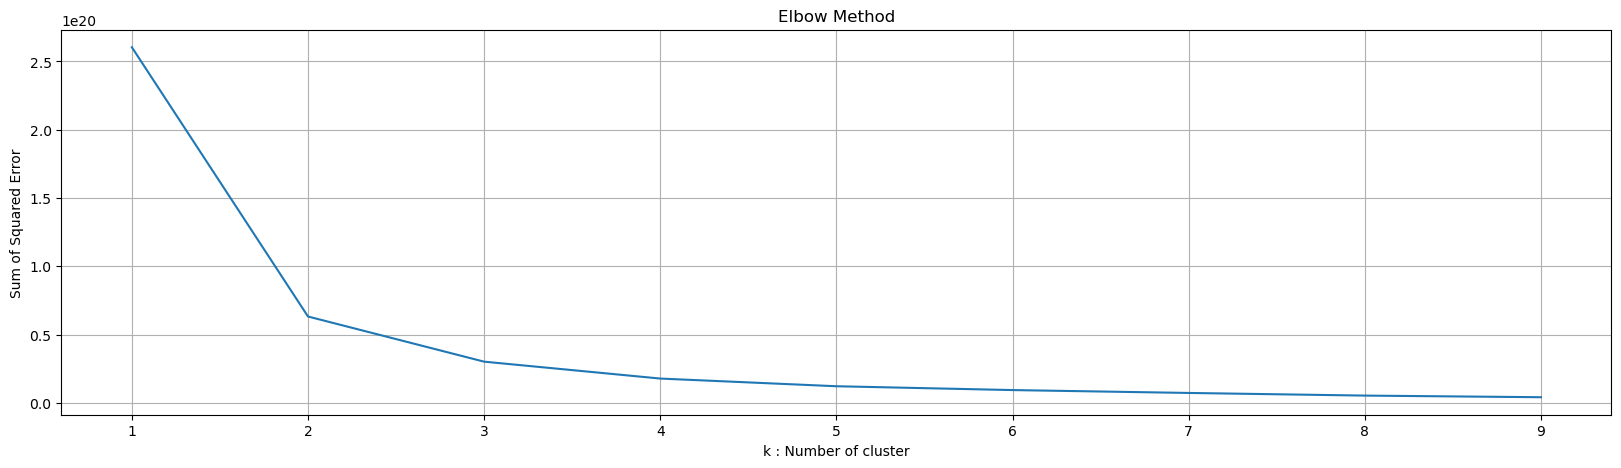

In [11]:
import warnings
warnings.filterwarnings('ignore')
sse = {};
kmax = 10
fig = plt.subplots(figsize = (20,5))

# Elbow Method :
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(user_data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

In [12]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 2,
               max_iter = 1000)
model.fit(user_data)

KMeans(max_iter=1000, n_clusters=2)

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [13]:
cluster = model.cluster_centers_
cluster

array([[8.72428534e+06, 6.73729348e+01, 6.53061813e+03],
       [1.09614980e+09, 7.19334331e+01, 3.58607516e+04]])

In [14]:
labels = model.labels_
labels
centroids= np.array(cluster)
centroids

array([[8.72428534e+06, 6.73729348e+01, 6.53061813e+03],
       [1.09614980e+09, 7.19334331e+01, 3.58607516e+04]])

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
distances = euclidean_distances(user_data, centroids)

less_engaged_cluster_index = 0

engagement_scores = distances[:, less_engaged_cluster_index]

mms = MinMaxScaler()
engagement_scores = mms.fit_transform(engagement_scores.reshape(-1, 1))

aggregated_data['Engagement Score'] = engagement_scores


aggregated_data

,MSISDN/Number,Avg_TCP_Retransmission,Avg_RTT,Handset_Type,Avg_Throughput,Engagement Score
0,3.360100e+10,1.078479e+07,23.000000,Huawei P20 Lite Huawei Nova 3E,38.000000,0.000961
1,3.360100e+10,1.078479e+07,15.500000,Apple iPhone 7 (A1778),49.500000,0.000961
2,3.360100e+10,1.078479e+07,63.729294,undefined,48.500000,0.000961
3,3.360101e+10,3.803623e+05,42.000000,Apple iPhone 5S (A1457),124.000000,0.003895
4,3.360101e+10,7.735101e+06,29.750000,Apple iPhone Se (A1723),14211.000000,0.000461
...,...,...,...,...,...,...
106852,3.379000e+10,1.078479e+07,20.000000,Apple iPhone 8 Plus (A1897),58.000000,0.000961
106853,4.188282e+10,8.491987e+06,154.561991,undefined,8479.471611,0.000108
106854,3.197020e+12,1.078479e+07,63.729294,Quectel Wireless. Quectel Ec25-E,0.500000,0.000961
106855,3.370000e+14,1.078479e+07,63.729294,Huawei B525S-23A,16.500000,0.000961


In [16]:
cluster_centroids = centroids

distances = euclidean_distances(user_data, cluster_centroids)

worst_experience_cluster_index = cluster_centroids.shape[0] - 1

experience_scores = distances[:, worst_experience_cluster_index]

mms = MinMaxScaler()
experience_scores = mms.fit_transform(experience_scores.reshape(-1, 1))

aggregated_data['Experience Score'] = experience_scores

aggregated_data

,MSISDN/Number,Avg_TCP_Retransmission,Avg_RTT,Handset_Type,Avg_Throughput,Engagement Score,Experience Score
0,3.360100e+10,1.078479e+07,23.000000,Huawei P20 Lite Huawei Nova 3E,38.000000,0.000961,0.990116
1,3.360100e+10,1.078479e+07,15.500000,Apple iPhone 7 (A1778),49.500000,0.000961,0.990116
2,3.360100e+10,1.078479e+07,63.729294,undefined,48.500000,0.000961,0.990116
3,3.360101e+10,3.803623e+05,42.000000,Apple iPhone 5S (A1457),124.000000,0.003895,0.999651
4,3.360101e+10,7.735101e+06,29.750000,Apple iPhone Se (A1723),14211.000000,0.000461,0.992911
...,...,...,...,...,...,...,...
106852,3.379000e+10,1.078479e+07,20.000000,Apple iPhone 8 Plus (A1897),58.000000,0.000961,0.990116
106853,4.188282e+10,8.491987e+06,154.561991,undefined,8479.471611,0.000108,0.992217
106854,3.197020e+12,1.078479e+07,63.729294,Quectel Wireless. Quectel Ec25-E,0.500000,0.000961,0.990116
106855,3.370000e+14,1.078479e+07,63.729294,Huawei B525S-23A,16.500000,0.000961,0.990116


In [17]:
aggregated_data['satisfaction_score'] = (aggregated_data['Engagement Score'] + aggregated_data['Experience Score']) / 2
top_10_satisfied_customers = aggregated_data.nlargest(10, 'satisfaction_score')

### Task 4.2 - Reporting Top 10 Satisfied Customers

In [18]:
top_10_satisfied_customers

,MSISDN/Number,Avg_TCP_Retransmission,Avg_RTT,Handset_Type,Avg_Throughput,Engagement Score,Experience Score,satisfaction_score
85785,3.369858e+10,2.150739e+09,243.0,Huawei B528S-23A,15883.0,1.000000,0.961909,0.980954
32273,3.365871e+10,2.144060e+09,40.5,Huawei B528S-23A,47091.0,0.996882,0.955788,0.976335
58026,3.366491e+10,2.134324e+09,226.5,Huawei B528S-23A,27604.5,0.992337,0.946864,0.969600
31942,3.365863e+10,2.127330e+09,44.0,Huawei B528S-23A,58566.5,0.989072,0.940454,0.964763
62049,3.366613e+10,2.105629e+09,104.0,Huawei B528S-23A,29800.0,0.978940,0.920565,0.949753
70079,3.366877e+10,2.083297e+09,86.0,Huawei B528S-23A,36136.0,0.968515,0.900098,0.934307
43629,3.366131e+10,2.068969e+09,40.5,Huawei B528S-23A,52501.5,0.961826,0.886966,0.924396
48341,3.366240e+10,2.058902e+09,32.0,Huawei B528S-23A,33839.0,0.957126,0.877740,0.917433
64113,3.366682e+10,1.984060e+09,78.5,Huawei B528S-23A,19659.5,0.922186,0.809146,0.865666
98211,3.376264e+10,1.893435e+09,34.0,Huawei B528S-23A,30143.5,0.879878,0.726087,0.802982


### Task 4.3 Building a Regression Model for Satisfaction Prediction

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X = aggregated_data[['Engagement Score', 'Experience Score']]
y = aggregated_data['satisfaction_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predict satisfaction scores for the test set
y_pred = regression_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

In [20]:
mse

6.307015052018032e-33

In [21]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 1.0


### Task 4.4 - Running k-means on Engagement and Experience Scores

In [22]:
scores = aggregated_data[['Engagement Score', 'Experience Score']]
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(scores)
aggregated_data['score_cluster'] = clusters

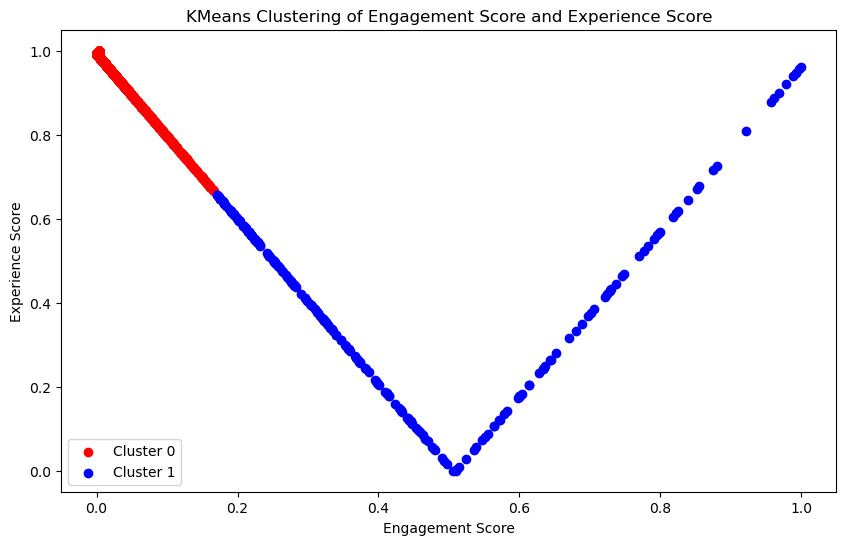

In [23]:

# Perform KMeans clustering on the 'Engagement Score' and 'Experience Score'
kmeans = KMeans(n_clusters=2, random_state=0)
clusters = kmeans.fit_predict(scores)

# Add the 'score_cluster' column to 'aggregated_data' to store the cluster information
aggregated_data['score_cluster'] = clusters

# Plotting the 'Engagement Score' and 'Experience Score' with the corresponding cluster using a scatter plot
plt.figure(figsize=(10, 6))  # Setting the figure size to make the plot more visible

# Scatter plot for cluster 0 (first cluster)
plt.scatter(aggregated_data[aggregated_data['score_cluster'] == 0]['Engagement Score'],
            aggregated_data[aggregated_data['score_cluster'] == 0]['Experience Score'],
            color='red', label='Cluster 0')

# Scatter plot for cluster 1 (second cluster)
plt.scatter(aggregated_data[aggregated_data['score_cluster'] == 1]['Engagement Score'],
            aggregated_data[aggregated_data['score_cluster'] == 1]['Experience Score'],
            color='blue', label='Cluster 1')

# Adding labels and title for the scatter plot
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.title('KMeans Clustering of Engagement Score and Experience Score')

# Adding legend to differentiate between clusters
plt.legend()

# Display the scatter plot
plt.show()

### Task 4.5 - Aggregating Average Satisfaction and Experience Scores per Cluster

In [24]:
cluster_agg = aggregated_data.groupby('score_cluster').agg({
    'satisfaction_score': 'mean',
    'Experience Score': 'mean'})

In [25]:
cluster_agg

,satisfaction_score,Experience Score
score_cluster,,
0,0.497259,0.992270
1,0.410716,0.400894


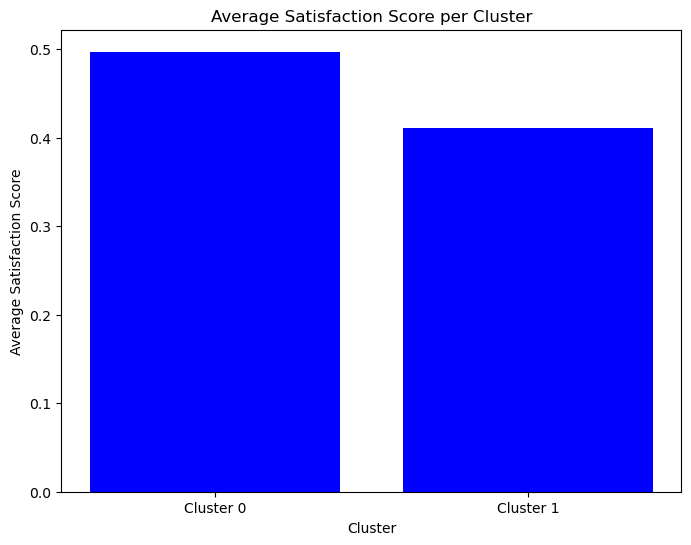

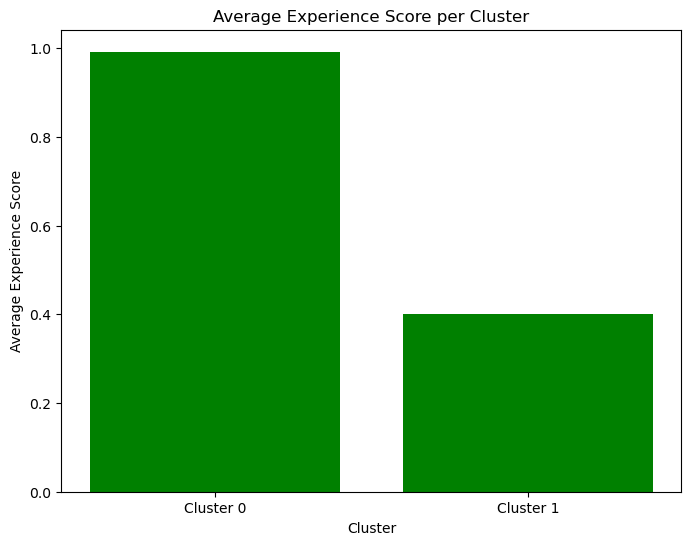

In [26]:

# Define the cluster labels and average scores
cluster_labels = ['Cluster 0', 'Cluster 1']
avg_satisfaction_scores = cluster_agg['satisfaction_score']
avg_experience_scores =cluster_agg['Experience Score']

# Plot the average satisfaction scores
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels, avg_satisfaction_scores, color='blue')
plt.xlabel('Cluster')
plt.ylabel('Average Satisfaction Score')
plt.title('Average Satisfaction Score per Cluster')

# Display the plot
plt.show()

# Plot the average experience scores
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels, avg_experience_scores, color='green')
plt.xlabel('Cluster')
plt.ylabel('Average Experience Score')
plt.title('Average Experience Score per Cluster')

# Display the plot
plt.show()

In [27]:

import pyodbc

# Connect to SQL Server database using Windows Authentication
server = 'DESKTOP-F2C0PH4\SQLEXPRESS'
database = 'Telco'
connection = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
import pyodbc


# Create a cursor object
cursor = connection.cursor()

# Create the table (if it doesn't exist) using a TRY...CATCH block
create_table_query = '''
    BEGIN TRY
        CREATE TABLE satisfaction_scores (
            MSISDN/Number INT,
            Engagement Score FLOAT,
            Experience Score FLOAT,
            satisfaction_score FLOAT
        )
    END TRY
    BEGIN CATCH
        -- Table already exists, no need to do anything
    END CATCH
'''

for _, row in aggregated_data.iterrows():
    insert_query = '''
        INSERT INTO satisfaction_scores (MSISDN/Number, Engagement Score, Experience Score, satisfaction_score)
        VALUES (?, ?, ?, ?)
    '''
    values = (row['MSISDN/Number'], row['Engagement Score'], row['Experience Score'], row['satisfaction_score'])
    

# Commit the changes and close the connection
cursor.commit()
connection.close()

OperationalError: ('08001', '[08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionOpen (Connect()). (53)')